# XGBoost metrics sandbox

Author: Jess Ewald

We are using PR-AUC to evaluate our classifiers. It's been suggested to used AUBPRC (Area under the balanced precision-recall curve) as this is less influenced by class imbalance. AUBPRC can be computed from PR-AUC based on the prior (proportion of positives in the population). 

It's unclear to me whether:

1 - PR-AUC is the same if the "1" and "0" labels are inverted. AUBPRC is not the same if you invert the "1" and "0" labels when converting from PR-AUC.

2 - the method for computing PR-AUC changes the estimates that much


### Findings
I've learned that:
- Using probability of predicting 1 instead of just the 0 and 1 labels REALLY MATTERS. The values change a lot. 
- There are different methods for computing AUPRC - the actual AUC method commonly used for AUROC and the 'average precision' method. Turns out that the PR-AUC curve is highly non-linear and so the linear interpolation used in the more common AUC metric is less appropriate and the average precision method is more correct. In practice in my data, when using 0,1 the resulting AUPRCs are super different between methods while they barely change when using the correct probability of 1. 
- AUPRC is not symmetric: you will get very different values if the 0 and 1 labels are inverted. It focuses on the precision and recall for the positive class, so if we do bad on that one then the entire score is terrible while if we do good on that one then the entire score is good. 


In our set-up, we care equally about both classes so it may not make sense to evaluate with this metric. I think the macro-averaged F1 score or the balanced accuracy may make more sense.

In [22]:
# Imports
import polars as pl
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import cupy as cp

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
dat_dir = "/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet"

In [3]:
def compute_aubprc(auprc, prior):
    return (auprc*(1-prior))/((auprc*(1-prior)) + ((1-auprc)*prior))

In [4]:
# get test data
dat = pl.scan_parquet(dat_dir)

In [31]:
allele_dat = dat.filter((pl.col("Metadata_gene_allele").is_in(["ACACB", "ACACB_Val1611Met"]))).collect()

In [32]:
meta_col = [i for i in allele_dat.columns if "Metadata_" in i]
feat_col = [i for i in allele_dat.columns if "Metadata_" not in i]
print(allele_dat.select("Metadata_Plate").to_series().unique().to_list())


['2024_01_22_B7A1R1_P4T3', '2024_01_19_B7A1R1_P4T1', '2024_01_23_B7A1R1_P4T2', '2024_01_22_B7A1R1_P4T4']


In [33]:
# Give labels
allele_dat = allele_dat.with_columns(
    pl.when(pl.col("Metadata_node_type") == "disease_wt")
    .then(1)
    .when(pl.col("Metadata_node_type") == "allele")
    .then(0)
    .otherwise(pl.lit(None))  # Handles cases where 'Metadata_node_type' might have other values
    .alias("Label")
)

In [8]:
test_plate = '2024_01_19_B7A1R1_P4T1'

In [23]:
def find_feat_cols(lframe):
    return [col for col in lframe.columns if not col.startswith('Metadata_')]

In [48]:
def classifier(
    df_train,
    df_test,
    target="Label",
    shuffle=False
):
    """
    This function runs classification.
    """
    
    feat_col = find_feat_cols(df_train)
    feat_col = [i for i in feat_col if i != "Label"]
    
    x_train, y_train = cp.array(df_train[feat_col].to_numpy()), df_train[[target]]
    x_test, y_test = cp.array(df_test[feat_col].to_numpy()), df_test[[target]]

    num_pos = df_train[df_train[target]==1].shape[0]
    num_neg = df_train[df_train[target]==0].shape[0]

    if (num_pos==0) or (num_neg==0):
        print(f'size of pos: {num_pos}, size of neg: {num_neg}')
        feat_importances = pd.Series(np.nan, index=df_train[feat_col].columns)
        return feat_importances, np.nan
    
    scale_pos_weight = num_neg/num_pos

    if (scale_pos_weight > 100) or (scale_pos_weight < 0.01):
        print(f'scale_pos_weight: {scale_pos_weight}, size of pos: {num_pos}, size of neg: {num_neg}')
        feat_importances = pd.Series(np.nan, index=df_train[feat_col].columns)
        return feat_importances, np.nan

    le = LabelEncoder()
    y_train = cp.array(le.fit_transform(y_train))
    y_test = cp.array(le.fit_transform(y_test))

    if shuffle:
        # Create shuffled train labels
        y_train_shuff = y_train.copy()
        y_train_shuff["Label"] = np.random.permutation(y_train.values)

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=150,
        tree_method="hist",
        device="cuda",
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight
    ).fit(x_train, y_train, verbose=False)

    # get predictions and scores
    pred_score = model.predict_proba(x_test)[:, 1]
    
    # Return classifier info
    info_0 = df_test[df_test['Label'] == 0].iloc[0]
    info_1 = df_test[df_test['Label'] == 1].iloc[0]
    class_ID = info_0["Metadata_Plate"] + "_" + info_0["Metadata_well_position"] + "_" + info_1["Metadata_well_position"]
    classifier_df = pd.DataFrame({
        "Classifier_ID": [class_ID],
        "Plate": [info_0["Metadata_Plate"]],
        "trainsize_0": [sum(y_train.get() == 0)],
        "testsize_0": [sum(y_test.get() == 0)],
        "well_0": [info_0["Metadata_well_position"]],
        "allele_0": [info_0["Metadata_gene_allele"]],
        "trainsize_1": [sum(y_train.get() == 1)],
        "testsize_1": [sum(y_test.get() == 1)],
        "well_1": [info_1["Metadata_well_position"]],
        "allele_1": [info_1["Metadata_gene_allele"]]
    })

    # Store feature importance
    feat_importances = pd.Series(model.feature_importances_, index=df_train[feat_col].columns)
    
    # Return cell-level predictions
    cellID = df_test.apply(lambda row: f"{row['Metadata_Plate']}_{row['Metadata_well_position']}_{row['Metadata_ImageNumber']}_{row['Metadata_ObjectNumber']}",
                            axis=1).to_list()
    
    pred_df = pd.DataFrame({"Classifier_ID": class_ID,
                            "CellID": cellID,
                            "Label": y_test.get(),
                            "Prediction": pred_score
                            })

    return feat_importances, classifier_df, pred_df

In [35]:
# split into train and test
df_train = allele_dat.filter(pl.col("Metadata_Plate") != test_plate).to_pandas()
df_test = allele_dat.filter(pl.col("Metadata_Plate") == test_plate).to_pandas()

x_train, y_train = cp.array(df_train[feat_col].to_numpy()), df_train[["Label"]]
x_test, y_test = cp.array(df_test[feat_col].to_numpy()), df_test[["Label"]]

le = LabelEncoder()
y_train = cp.array(le.fit_transform(y_train))
y_test = cp.array(le.fit_transform(y_test))

In [49]:
feat_importances, classifier_df, pred_df = classifier(df_train, df_test, target="Label")

In [52]:
feat_importances

Nuclei_Texture_SumVariance_DNA_10_01_256                  0.003840
Cells_Texture_Correlation_DNA_20_01_256                   0.004149
Nuclei_Texture_InfoMeas1_AGP_10_01_256                    0.000000
Cytoplasm_Granularity_2_Mito                              0.000000
Cytoplasm_Texture_Correlation_Brightfield_20_02_256       0.000000
                                                            ...   
Nuclei_Correlation_K_Brightfield_H_Brightfield            0.000449
Cells_RadialDistribution_MeanFrac_mito_tubeness_10of16    0.000000
Nuclei_Texture_Correlation_Mito_5_03_256                  0.000000
Nuclei_Texture_SumVariance_Mito_10_03_256                 0.000000
Cytoplasm_Texture_Correlation_Brightfield_10_00_256       0.000000
Length: 1500, dtype: float32

In [10]:
# Calculate imbalance
num_pos = df_train.filter(pl.col("Metadata_Label") == 1).shape[0]
num_neg = df_train.filter(pl.col("Metadata_Label") == 0).shape[0]
train_pos_weight = num_neg/num_pos
train_pos_weight

1.2318840579710144

In [11]:
# train model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=150,
    tree_method="hist",
    learning_rate=0.05,
    device="cuda",
    scale_pos_weight=train_pos_weight
).fit(x_train, y_train, verbose=False)

preds = model.predict(x_test)
prob_pos_class = model.predict_proba(x_test)[:,1]

In [12]:
# calculate prior, tp, fp, tn, fn
prior = sum(y_test == 1)/len(y_test)
prior, len(y_test), sum(y_test==1)

(array(0.07540984), 305, array(23))

In [13]:
pred_score = model.predict_proba(x_test)[:, 1]

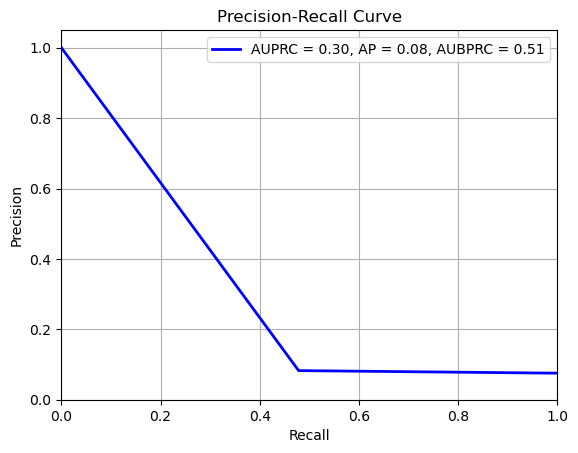

In [69]:
# Compute PR-AUC with binary scores
precision, recall, _ = precision_recall_curve(y_test, preds)
pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_test, preds, average="weighted")
balanced_ap = compute_aubprc(average_precision, prior)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, 
         label='AUPRC = %0.2f, AP = %0.2f, AUBPRC = %0.2f' % (pr_auc, average_precision, balanced_ap))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

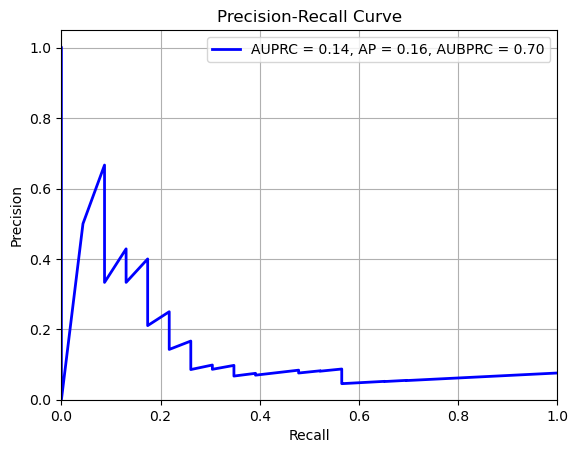

In [70]:
# Compute PR-AUC with positive probability scores
precision, recall, _ = precision_recall_curve(y_test, prob_pos_class)
pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_test, prob_pos_class, average="weighted")
balanced_ap = compute_aubprc(average_precision, prior)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, 
         label='AUPRC = %0.2f, AP = %0.2f, AUBPRC = %0.2f' % (pr_auc, average_precision, balanced_ap))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

### Invert the labels and re-calculate

Training #neg/#pos:  0.8117647058823529
Prior:  0.9245901639344263 305 282


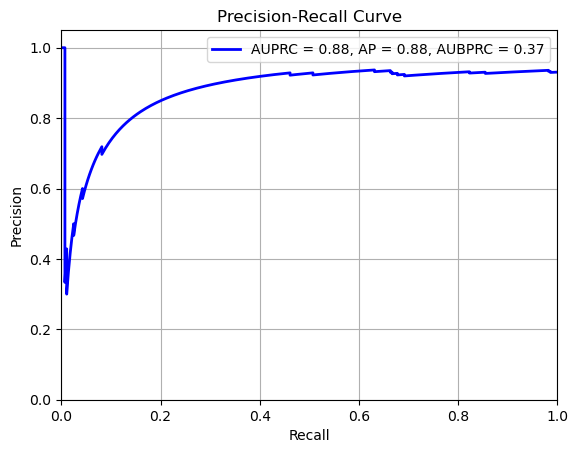

In [73]:
# Give labels
allele_dat = allele_dat.with_columns(
    pl.when(pl.col("Metadata_node_type") == "disease_wt")
    .then(0)
    .when(pl.col("Metadata_node_type") == "allele")
    .then(1)
    .otherwise(pl.lit(None))  # Handles cases where 'Metadata_node_type' might have other values
    .alias("Metadata_Label")
)

# split into train and test
df_train = allele_dat.filter(pl.col("Metadata_Plate") != test_plate)
df_test = allele_dat.filter(pl.col("Metadata_Plate") == test_plate)

x_train, y_train = df_train.select(feat_col), df_train.select("Metadata_Label")
x_test, y_test = df_test.select(feat_col), df_test.select("Metadata_Label")

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Calculate imbalance
num_pos = df_train.filter(pl.col("Metadata_Label") == 1).shape[0]
num_neg = df_train.filter(pl.col("Metadata_Label") == 0).shape[0]
train_pos_weight = num_neg/num_pos
print("Training #neg/#pos: ", train_pos_weight)

# train model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=150,
    tree_method="hist",
    learning_rate=0.05,
    scale_pos_weight=train_pos_weight
).fit(x_train, y_train, verbose=False)

preds = model.predict(x_test)
prob_pos_class = model.predict_proba(x_test)[:, 1]

# calculate prior
prior = sum(y_test == 1)/len(y_test)
print("Prior: ", prior, len(y_test), sum(y_test==1))


# Compute PR-AUC with positive probability scores
precision, recall, _ = precision_recall_curve(y_test, prob_pos_class)
pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_test, prob_pos_class, average="weighted")
balanced_ap = compute_aubprc(average_precision, prior)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, 
         label='AUPRC = %0.2f, AP = %0.2f, AUBPRC = %0.2f' % (pr_auc, average_precision, balanced_ap))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

In [24]:
# create test data for snakemake pipeline
import polars as pl

dat = pl.scan_parquet("/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet")

variants = dat.filter(pl.col("Metadata_plate_map_name") == "B7A1R1_P1").select("Metadata_gene_allele").collect().to_series().unique().to_list()
variants = [i for i in variants if i is not None]

In [21]:
var1 = [i for i in variants if "FA2H" in i]
var2 = [i for i in variants if "ALAS2" in i]
filtered_variants = var1 + var2 + ["MAPK9", "RHEB"]

In [25]:
dat = dat.filter((pl.col("Metadata_gene_allele").is_in(filtered_variants))
                 & (pl.col("Metadata_plate_map_name") == "B7A1R1_P1")).collect()

In [27]:
dat.write_parquet("/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/test_batch/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet", compression="gzip")

In [32]:
# check results
res_dir="/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results/test_batch/profiles_tcdropped_filtered_var_mad_outlier_featselect"

preds = pl.read_parquet(f"{res_dir}/predictions.parquet")
info = pl.read_csv(f"{res_dir}/result.csv")

In [31]:
info

Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control
str,str,i64,i64,str,str,i64,i64,str,str,bool
"""2024_01_17_B7A…","""2024_01_17_B7A…",2120,820,"""L14""","""MAPK9""",1831,713,"""K14""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2300,640,"""L14""","""MAPK9""",1993,551,"""K14""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2155,785,"""L14""","""MAPK9""",1969,575,"""K14""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2245,695,"""L14""","""MAPK9""",1839,705,"""K14""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2120,820,"""L14""","""MAPK9""",1914,552,"""K13""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2300,640,"""L14""","""MAPK9""",2049,417,"""K13""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2155,785,"""L14""","""MAPK9""",1683,783,"""K13""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",2245,695,"""L14""","""MAPK9""",1752,714,"""K13""","""MAPK9""",true
"""2024_01_17_B7A…","""2024_01_17_B7A…",1877,723,"""L13""","""MAPK9""",1914,552,"""K13""","""MAPK9""",true
